In [1]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.models import mobilenet_v3_large
import onnxruntime as ort

In [2]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [3]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.VAL_PATH_MIXED = os.path.join(_C.ROOT_PATH, 'test_mixed')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 512
_C.IMAGE_H = 512
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [4]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'demoir_blur', 'haze', 'rain', 'rain_blur']
6


In [5]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [6]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [8]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [9]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor()])

In [10]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

38299
7629


Label: blur demoir
mask: blur demoir

tensor([1., 1., 0., 0.])
../data/train/demoir_blur/27_0001_moire.jpg


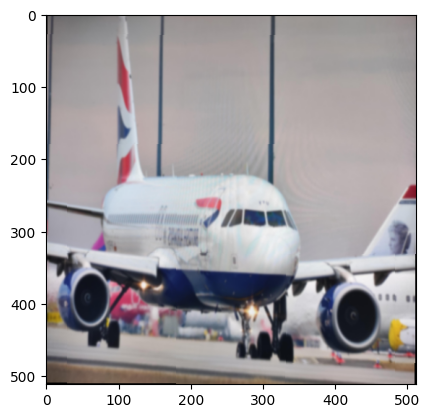

In [11]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[18000])
print(train_dataset.im_path(18000))

Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

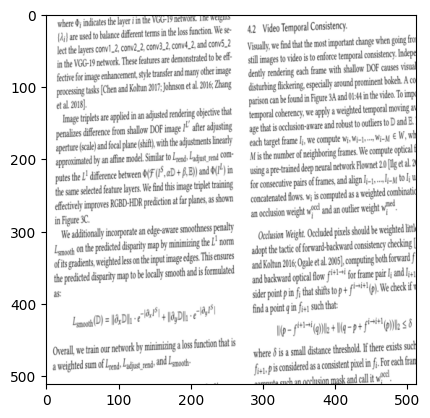

In [12]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [13]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [14]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [15]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [16]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

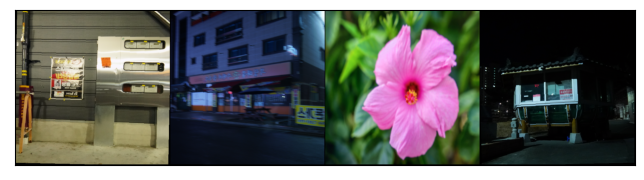

In [17]:
def show_batch(dl, nmax=16):
    for images, labels, masks in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [20]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [21]:
images, targets, masks = next(iter(val_loader))
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(1.), tensor(0.7500), tensor(0.8571))


In [22]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [23]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets, masks = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets, masks = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [25]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [26]:
# checking up the shapes of the datas
for xb, yb, masks in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 512, 512])
torch.Size([4, 4])
torch.Size([4, 4])


In [27]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = mobilevit_s().to(device)
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    l2_lambda = 0.001
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [28]:
from einops import rearrange


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)
    
    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(MultilabelImageClassificationBase):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))
        
        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


def mobilevit_xxs():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4, expansion=2)


def mobilevit_xs():
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4)


def mobilevit_s():
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
    return MobileViT((_C.IMAGE_W, _C.IMAGE_H), dims, channels, num_classes=4)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [29]:
model = mobilevit_s().to(device)
count_parameters(model)

4999280

In [30]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 512, 512])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.4918, 0.5278, 0.5095, 0.5256],
        [0.4876, 0.5174, 0.5040, 0.5231]], device='cuda:0')


In [31]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(3477078016, 20104192)

In [32]:
epochs = 10
max_lr = 0.001
grad_clip = 0.8
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.12976799056232793, rec 0.999999999999999, f2 0.22972502610491316
demoir
prec 0.0, rec 0.0, f2 0.0
haze
prec 0.15729453401494295, rec 0.9999999999999992, f2 0.27183146449178003
rain
prec 0.13409359024773887, rec 0.999999999999999, f2 0.2364771151176832


[{'val_loss': 0.6933096647262573,
  'val_score': 0.23712177121744957,
  'val_score_blur': 0.22972502610491316,
  'val_score_haze': 0.27183146449178003,
  'val_score_rain': 0.2364771151176832,
  'val_score_demoir': 0.0}]

In [34]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7112676056338023, rec 0.9181818181818172, f2 0.8015873015868089
demoir
prec 0.7433712121212115, rec 0.7849999999999991, f2 0.763618677042301
haze
prec 0.9195046439628477, rec 0.9899999999999992, f2 0.9534510433381838
rain
prec 0.7933962264150937, rec 0.8220918866080148, f2 0.8074891982712228
Epoch [0], last_lr: 0.0003, train_loss: 0.2581, val_loss: 0.1295, val_score: 0.8367, val_score_blur: 0.8016, val_score_demoir: 0.7636, val_score_haze: 0.9535, val_score_rain: 0.8075


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6591251885369528, rec 0.882828282828282, f2 0.7547495682205807
demoir
prec 0.8418367346938767, rec 0.8249999999999992, f2 0.8333333333328323
haze
prec 0.9534109816971706, rec 0.9549999999999993, f2 0.9542048293084084
rain
prec 0.7130942452043364, rec 0.8357771260997059, f2 0.769576957695272
Epoch [1], last_lr: 0.0008, train_loss: 0.1806, val_loss: 0.1409, val_score: 0.8296, val_score_blur: 0.7547, val_score_demoir: 0.8333, val_score_haze: 0.9542, val_score_rain: 0.7696


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6606864274570978, rec 0.8555555555555546, f2 0.7455985915488033
demoir
prec 0.9084362139917685, rec 0.8829999999999991, f2 0.8955375253544687
haze
prec 0.9370574350904792, rec 0.9924999999999993, f2 0.9639821934434494
rain
prec 0.7505957108816516, rec 0.9237536656891486, f2 0.8282208588952101
Epoch [2], last_lr: 0.0010, train_loss: 0.1602, val_loss: 0.1271, val_score: 0.8594, val_score_blur: 0.7456, val_score_demoir: 0.8955, val_score_haze: 0.9640, val_score_rain: 0.8282


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7773073666384414, rec 0.9272727272727264, f2 0.845693228926265
demoir
prec 0.9126016260162592, rec 0.8979999999999991, f2 0.9052419354833701
haze
prec 0.8233676975945012, rec 0.9983333333333326, f2 0.9024482109222912
rain
prec 0.8067765567765561, rec 0.8611925708699893, f2 0.8330969267134477
Epoch [3], last_lr: 0.0010, train_loss: 0.1329, val_loss: 0.0986, val_score: 0.8728, val_score_blur: 0.8457, val_score_demoir: 0.9052, val_score_haze: 0.9024, val_score_rain: 0.8331


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7779799818016372, rec 0.8636363636363628, f2 0.818573480133536
demoir
prec 0.8801141769743094, rec 0.924999999999999, f2 0.9019990248654185
haze
prec 0.9778869778869772, rec 0.9949999999999992, f2 0.9863692688966492
rain
prec 0.5690826727066814, rec 0.9824046920821105, f2 0.720688418787631
Epoch [4], last_lr: 0.0008, train_loss: 0.1062, val_loss: 0.1144, val_score: 0.8511, val_score_blur: 0.8186, val_score_demoir: 0.9020, val_score_haze: 0.9864, val_score_rain: 0.7207


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7890295358649783, rec 0.9444444444444434, f2 0.8597701149420319
demoir
prec 0.9090909090909082, rec 0.8999999999999991, f2 0.9045226130648257
haze
prec 0.9966187658495343, rec 0.9824999999999993, f2 0.9895090222403721
rain
prec 0.6516853932584266, rec 0.9638318670576725, f2 0.7776025236588241
Epoch [5], last_lr: 0.0006, train_loss: 0.0841, val_loss: 0.1037, val_score: 0.8807, val_score_blur: 0.8598, val_score_demoir: 0.9045, val_score_haze: 0.9895, val_score_rain: 0.7776


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8420560747663545, rec 0.9101010101010092, f2 0.8747572815528979
demoir
prec 0.9315738025415435, rec 0.9529999999999991, f2 0.9421651013341505
haze
prec 0.9949238578680153, rec 0.16333333333333322, f2 0.2806012884750616
rain
prec 0.7655279503105584, rec 0.9638318670576725, f2 0.8533102553002414
Epoch [6], last_lr: 0.0004, train_loss: 0.0671, val_loss: 0.2402, val_score: 0.7794, val_score_blur: 0.8748, val_score_demoir: 0.9422, val_score_haze: 0.2806, val_score_rain: 0.8533


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8528896672504371, rec 0.9838383838383828, f2 0.9136960600370252
demoir
prec 0.8519823788546249, rec 0.966999999999999, f2 0.9058548009362694
haze
prec 0.929512006196746, rec 0.9999999999999992, f2 0.9634684865510855
rain
prec 0.6782549420586226, rec 0.9726295210166168, f2 0.7991967871481095
Epoch [7], last_lr: 0.0002, train_loss: 0.0537, val_loss: 0.0890, val_score: 0.8945, val_score_blur: 0.9137, val_score_demoir: 0.9059, val_score_haze: 0.9635, val_score_rain: 0.7992


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8511013215859023, rec 0.9757575757575747, f2 0.9091764705877368
demoir
prec 0.8492550394390879, rec 0.968999999999999, f2 0.9051844932269651
haze
prec 0.9779951100244492, rec 0.9999999999999992, f2 0.9888751545112422
rain
prec 0.7560606060606055, rec 0.9755620723362649, f2 0.8518992744339929
Epoch [8], last_lr: 0.0000, train_loss: 0.0444, val_loss: 0.0732, val_score: 0.9148, val_score_blur: 0.9092, val_score_demoir: 0.9052, val_score_haze: 0.9889, val_score_rain: 0.8519


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9165867689357614, rec 0.9656565656565647, f2 0.9404820462365874
demoir
prec 0.9369458128078808, rec 0.9509999999999991, f2 0.9439205955329978
haze
prec 0.9739130434782567, rec 0.18666666666666654, f2 0.313286713286443
rain
prec 0.6808367071524962, rec 0.9863147605083079, f2 0.8055888223548057
Epoch [9], last_lr: 0.0000, train_loss: 0.0390, val_loss: 0.1760, val_score: 0.7867, val_score_blur: 0.9405, val_score_demoir: 0.9439, val_score_haze: 0.3133, val_score_rain: 0.8056
CPU times: user 2h 44min 59s, sys: 9min 51s, total: 2h 54min 50s
Wall time: 3h 19min 48s


In [35]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8704200178731003, rec 0.9838383838383828, f2 0.9236605026073721
demoir
prec 0.9222648752399224, rec 0.960999999999999, f2 0.941234084230645
haze
prec 0.992537313432835, rec 0.9974999999999993, f2 0.9950124688274292
rain
prec 0.8148148148148142, rec 0.96774193548387, f2 0.8847184986590204
Epoch [0], last_lr: 0.0003, train_loss: 0.0404, val_loss: 0.0582, val_score: 0.9374, val_score_blur: 0.9237, val_score_demoir: 0.9412, val_score_haze: 0.9950, val_score_rain: 0.8847


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.6855123674911656, rec 0.9797979797979788, f2 0.8066528066523215
demoir
prec 0.6013555144793589, rec 0.975999999999999, f2 0.7441860465111556
haze
prec 0.9991624790619758, rec 0.9941666666666659, f2 0.9966583124472853
rain
prec 0.8458070333633897, rec 0.9169110459433031, f2 0.8799249530951847
Epoch [1], last_lr: 0.0008, train_loss: 0.0625, val_loss: 0.1406, val_score: 0.8535, val_score_blur: 0.8067, val_score_demoir: 0.7442, val_score_haze: 0.9967, val_score_rain: 0.8799


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.687907313540912, rec 0.9595959595959586, f2 0.8013496415009892
demoir
prec 0.9346076458752506, rec 0.928999999999999, f2 0.9317953861579744
haze
prec 0.937402190923317, rec 0.9983333333333326, f2 0.9669087974167717
rain
prec 0.7909090909090903, rec 0.935483870967741, f2 0.8571428571423599
Epoch [2], last_lr: 0.0010, train_loss: 0.0795, val_loss: 0.1073, val_score: 0.8889, val_score_blur: 0.8013, val_score_demoir: 0.9318, val_score_haze: 0.9669, val_score_rain: 0.8571


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7663088356729969, rec 0.9373737373737364, f2 0.8432530667873279
demoir
prec 0.9246031746031736, rec 0.931999999999999, f2 0.9282868525891406
haze
prec 0.9630818619582657, rec 0.9999999999999992, f2 0.9811937857721894
rain
prec 0.6715916722632636, rec 0.9775171065493636, f2 0.7961783439485611
Epoch [3], last_lr: 0.0010, train_loss: 0.0771, val_loss: 0.1086, val_score: 0.8858, val_score_blur: 0.8433, val_score_demoir: 0.9283, val_score_haze: 0.9812, val_score_rain: 0.7962


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9058935361216722, rec 0.9626262626262616, f2 0.9333986287947983
demoir
prec 0.8779385171790228, rec 0.970999999999999, f2 0.9221272554600892
haze
prec 0.9716599190283394, rec 0.9999999999999992, f2 0.9856262833670557
rain
prec 0.7300521998508571, rec 0.956989247311827, f2 0.8282571912008619
Epoch [4], last_lr: 0.0008, train_loss: 0.0686, val_loss: 0.0715, val_score: 0.9172, val_score_blur: 0.9334, val_score_demoir: 0.9221, val_score_haze: 0.9856, val_score_rain: 0.8283


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.5391780821917805, rec 0.9939393939393929, f2 0.6991119005324032
demoir
prec 0.8412424503882651, rec 0.974999999999999, f2 0.9031959240384089
haze
prec 0.9973776223776216, rec 0.9508333333333326, f2 0.973549488054107
rain
prec 0.6807928913192067, rec 0.9736070381231662, f2 0.8012872083663695
Epoch [5], last_lr: 0.0006, train_loss: 0.0596, val_loss: 0.1900, val_score: 0.8356, val_score_blur: 0.6991, val_score_demoir: 0.9032, val_score_haze: 0.9735, val_score_rain: 0.8013


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9195171026156932, rec 0.9232323232323223, f2 0.9213709677414346
demoir
prec 0.9066918001885006, rec 0.961999999999999, f2 0.9335274138762584
haze
prec 0.9630818619582657, rec 0.9999999999999992, f2 0.9811937857721894
rain
prec 0.7898140662894093, rec 0.9550342130987283, f2 0.864601769911008
Epoch [6], last_lr: 0.0004, train_loss: 0.0504, val_loss: 0.0616, val_score: 0.9263, val_score_blur: 0.9214, val_score_demoir: 0.9335, val_score_haze: 0.9812, val_score_rain: 0.8646


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8559928443649367, rec 0.9666666666666657, f2 0.9079696394681918
demoir
prec 0.9587525150905423, rec 0.9529999999999991, f2 0.9558676028079244
haze
prec 0.9942004971002478, rec 0.9999999999999992, f2 0.9970918155375134
rain
prec 0.731277533039647, rec 0.9736070381231662, f2 0.8352201257856728
Epoch [7], last_lr: 0.0002, train_loss: 0.0414, val_loss: 0.0762, val_score: 0.9233, val_score_blur: 0.9080, val_score_demoir: 0.9559, val_score_haze: 0.9971, val_score_rain: 0.8352


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.7962510187449057, rec 0.9868686868686859, f2 0.8813712223720804
demoir
prec 0.9078212290502785, rec 0.974999999999999, f2 0.9402121504334437
haze
prec 0.9909165978530133, rec 0.9999999999999992, f2 0.99543757776806
rain
prec 0.7700077700077694, rec 0.9687194525904194, f2 0.8580086580081638
Epoch [8], last_lr: 0.0000, train_loss: 0.0333, val_loss: 0.0815, val_score: 0.9194, val_score_blur: 0.8814, val_score_demoir: 0.9402, val_score_haze: 0.9954, val_score_rain: 0.8580


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8639999999999993, rec 0.9818181818181808, f2 0.9191489361697139
demoir
prec 0.925855513307984, rec 0.973999999999999, f2 0.9493177387909224
haze
prec 0.9942004971002478, rec 0.9999999999999992, f2 0.9970918155375134
rain
prec 0.7771653543307081, rec 0.9648093841642219, f2 0.8608809419968884
Epoch [9], last_lr: 0.0000, train_loss: 0.0305, val_loss: 0.0655, val_score: 0.9322, val_score_blur: 0.9191, val_score_demoir: 0.9493, val_score_haze: 0.9971, val_score_rain: 0.8609


In [36]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8294970161977828, rec 0.9828282828282818, f2 0.8996763754040334
demoir
prec 0.9575757575757566, rec 0.9479999999999991, f2 0.9527638190949764
haze
prec 0.9411764705882346, rec 0.9999999999999992, f2 0.9696969696964693
rain
prec 0.7889688249400474, rec 0.9648093841642219, f2 0.8680738786274727
Epoch [0], last_lr: 0.0003, train_loss: 0.0306, val_loss: 0.0739, val_score: 0.9229, val_score_blur: 0.8997, val_score_demoir: 0.9528, val_score_haze: 0.9697, val_score_rain: 0.8681


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8394160583941599, rec 0.9292929292929283, f2 0.8820709491845434
demoir
prec 0.8839122486288841, rec 0.966999999999999, f2 0.9235912129889939
haze
prec 0.9950248756218898, rec 0.9999999999999992, f2 0.9975062344134642
rain
prec 0.7043048694424837, rec 0.9755620723362649, f2 0.8180327868847582
Epoch [1], last_lr: 0.0008, train_loss: 0.0460, val_loss: 0.0854, val_score: 0.9052, val_score_blur: 0.8821, val_score_demoir: 0.9236, val_score_haze: 0.9975, val_score_rain: 0.8180


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.5919471153846151, rec 0.9949494949494939, f2 0.742275810097497
demoir
prec 0.5248264815803522, rec 0.982999999999999, f2 0.684302123215696
haze
prec 0.9661835748792263, rec 0.9999999999999992, f2 0.9828009828004821
rain
prec 0.8050314465408799, rec 0.8758553274682298, f2 0.8389513108609232
Epoch [2], last_lr: 0.0010, train_loss: 0.0635, val_loss: 0.2530, val_score: 0.8044, val_score_blur: 0.7423, val_score_demoir: 0.6843, val_score_haze: 0.9828, val_score_rain: 0.8390


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8052805280528047, rec 0.9858585858585849, f2 0.8864668483192136
demoir
prec 0.9614984391259095, rec 0.923999999999999, f2 0.9423763386022528
haze
prec 0.9843621399176947, rec 0.9966666666666659, f2 0.9904761904756897
rain
prec 0.7691699604743077, rec 0.9511241446725308, f2 0.8505244755239804
Epoch [3], last_lr: 0.0010, train_loss: 0.0625, val_loss: 0.0639, val_score: 0.9179, val_score_blur: 0.8865, val_score_demoir: 0.9424, val_score_haze: 0.9905, val_score_rain: 0.8505


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8880455407969632, rec 0.9454545454545444, f2 0.915851272015155
demoir
prec 0.7950207468879662, rec 0.9579999999999991, f2 0.8689342403623154
haze
prec 0.9599679743795029, rec 0.9991666666666659, f2 0.97917517353972
rain
prec 0.7736156351791525, rec 0.9286412512218954, f2 0.8440693025317113
Epoch [4], last_lr: 0.0008, train_loss: 0.0582, val_loss: 0.0909, val_score: 0.9036, val_score_blur: 0.9159, val_score_demoir: 0.8689, val_score_haze: 0.9792, val_score_rain: 0.8441


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8557692307692301, rec 0.9888888888888878, f2 0.917525773195378
demoir
prec 0.903286384976525, rec 0.961999999999999, f2 0.9317191283287973
haze
prec 0.9999999999999992, rec 0.9999999999999992, f2 0.9999999999994993
rain
prec 0.7652982184353209, rec 0.9657869012707713, f2 0.8539325842691687
Epoch [5], last_lr: 0.0006, train_loss: 0.0493, val_loss: 0.0621, val_score: 0.9265, val_score_blur: 0.9175, val_score_demoir: 0.9317, val_score_haze: 1.0000, val_score_rain: 0.8539


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8576449912126531, rec 0.9858585858585849, f2 0.9172932330822084
demoir
prec 0.9873684210526306, rec 0.9379999999999991, f2 0.9620512820507814
haze
prec 0.9811629811629804, rec 0.9983333333333326, f2 0.9896736885579461
rain
prec 0.8294168842471707, rec 0.9315738025415435, f2 0.8775322283604584
Epoch [6], last_lr: 0.0004, train_loss: 0.0428, val_loss: 0.0741, val_score: 0.9376, val_score_blur: 0.9173, val_score_demoir: 0.9621, val_score_haze: 0.9897, val_score_rain: 0.8775


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9486166007905129, rec 0.9696969696969687, f2 0.9590409590404582
demoir
prec 0.8244592346089844, rec 0.990999999999999, f2 0.9000908265208475
haze
prec 0.9991673605328885, rec 0.9999999999999992, f2 0.9995835068716358
rain
prec 0.7616146230007611, rec 0.9775171065493636, f2 0.8561643835611508
Epoch [7], last_lr: 0.0002, train_loss: 0.0358, val_loss: 0.0650, val_score: 0.9285, val_score_blur: 0.9590, val_score_demoir: 0.9001, val_score_haze: 0.9996, val_score_rain: 0.8562


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.890423572744014, rec 0.9767676767676757, f2 0.9315992292865908
demoir
prec 0.906740535549399, rec 0.981999999999999, f2 0.9428708593369939
haze
prec 0.9999999999999992, rec 0.9983333333333326, f2 0.9991659716425352
rain
prec 0.8214876033057845, rec 0.9716520039100675, f2 0.8902821316609447
Epoch [8], last_lr: 0.0000, train_loss: 0.0286, val_loss: 0.0652, val_score: 0.9422, val_score_blur: 0.9316, val_score_demoir: 0.9429, val_score_haze: 0.9992, val_score_rain: 0.8903


  0%|          | 0/9575 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9370155038759682, rec 0.9767676767676757, f2 0.9564787339263043
demoir
prec 0.9299242424242417, rec 0.981999999999999, f2 0.9552529182874372
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.8171334431630966, rec 0.9696969696969687, f2 0.8869021010276654
Epoch [9], last_lr: 0.0000, train_loss: 0.0259, val_loss: 0.0506, val_score: 0.9499, val_score_blur: 0.9565, val_score_demoir: 0.9553, val_score_haze: 0.9983, val_score_rain: 0.8869


In [37]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9370155038759682, rec 0.9767676767676757, f2 0.9564787339263043
demoir
prec 0.9299242424242417, rec 0.981999999999999, f2 0.9552529182874372
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.8171334431630966, rec 0.9696969696969687, f2 0.8869021010276654


{'val_loss': 0.05059396103024483,
 'val_score': 0.9498795733450673,
 'val_score_blur': 0.9564787339263043,
 'val_score_haze': 0.9983361064886838,
 'val_score_rain': 0.8869021010276654,
 'val_score_demoir': 0.9552529182874372}

In [38]:
import time

In [39]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    starttime = time.time()
    preds = model(xb)
    torch.cuda.synchronize()
    print(1000*(time.time() - starttime))
    prediction = preds[0]
    show_example(image, prediction, mask)

86.3652229309082
Label: clear
mask: blur

tensor([0.0134, 0.0001, 0.0003, 0.0112], device='cuda:0',
       grad_fn=<SelectBackward0>)


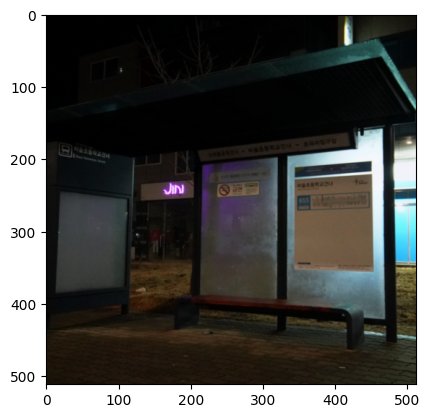

In [40]:
predict_single(*val_dataset[1497])

In [41]:
val_dataset.im_path(1497)

'../data/test/blur/clear_gt/real_blur/gt_489.png'

18.822908401489258
Label: blur rain
mask: blur

tensor([0.7793, 0.0073, 0.0091, 0.7531], device='cuda:0',
       grad_fn=<SelectBackward0>)


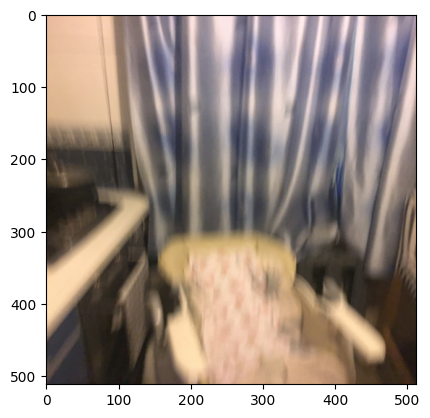

In [42]:
predict_single(*val_dataset[57])

In [43]:
val_dataset.im_path(57)

'../data/test/blur/35_IPHONE-6S_M.jpeg'

Label: clear
mask: blur

tensor([0., 0., 0., 0.])


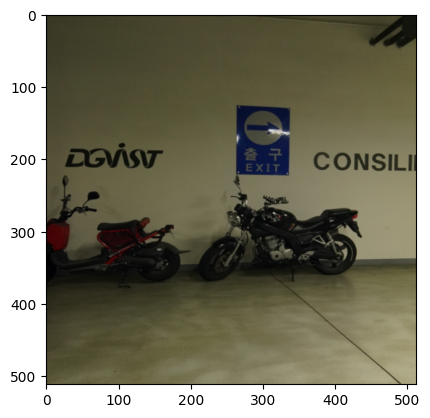

In [44]:
show_example(*val_dataset[1258])

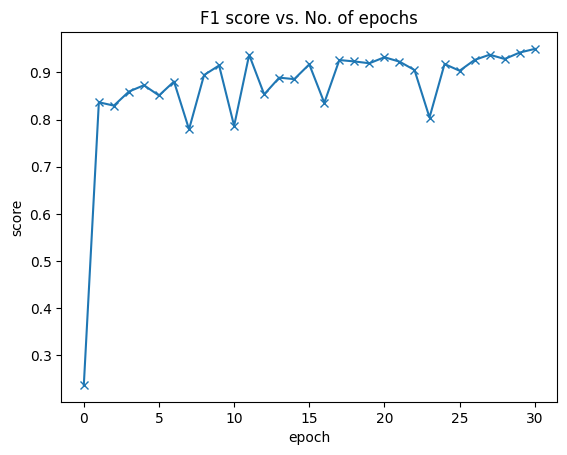

In [45]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

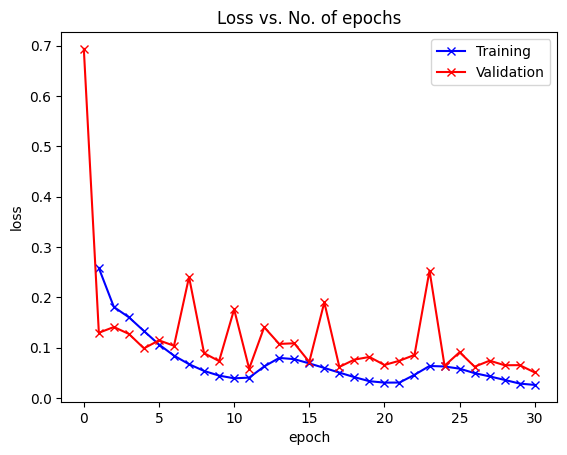

In [46]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

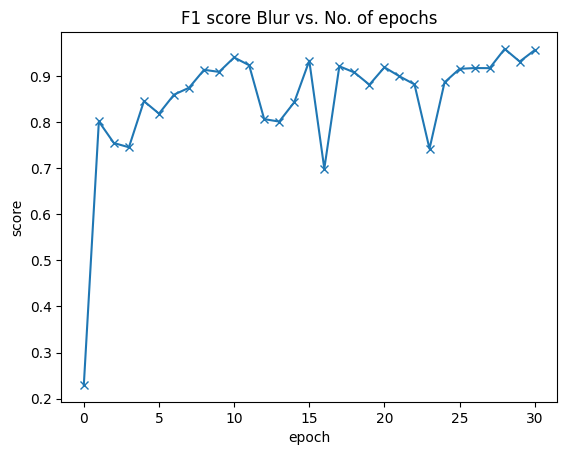

In [47]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

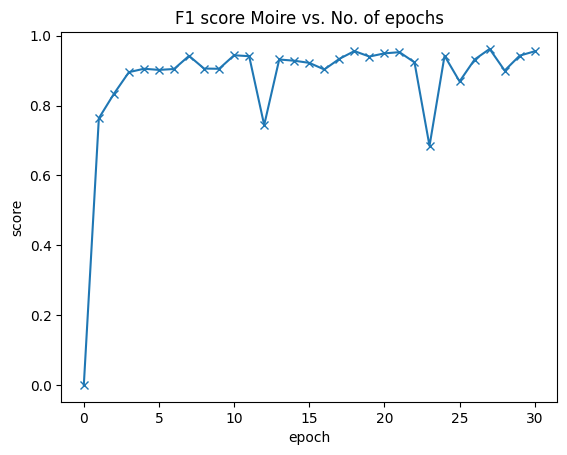

In [48]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

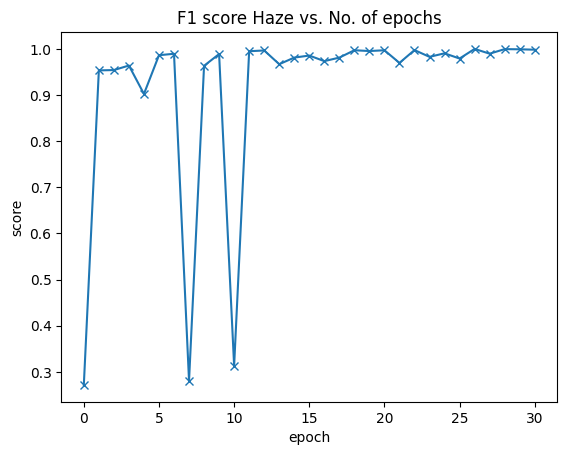

In [49]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

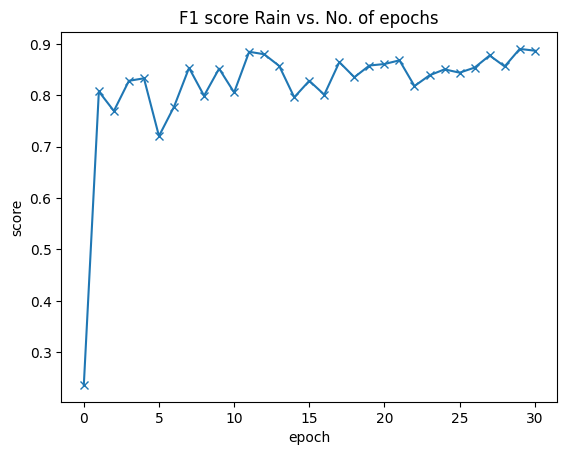

In [50]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

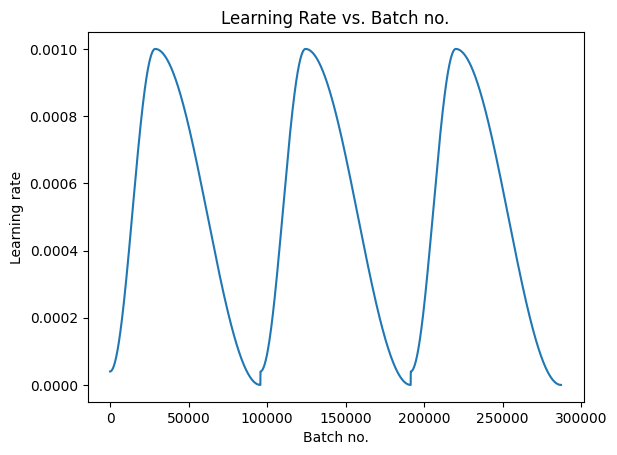

In [51]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [52]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([0.2112, 0.2373, 0.7314, 0.0100], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


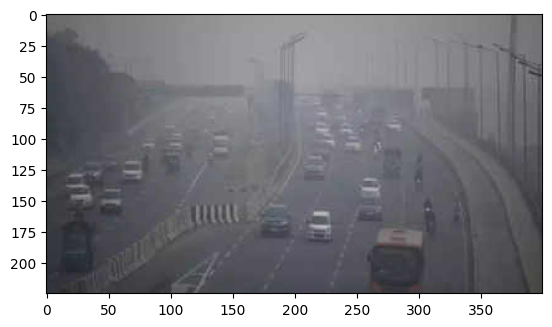

In [53]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([0.0506, 0.5517, 0.1145, 0.2117], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


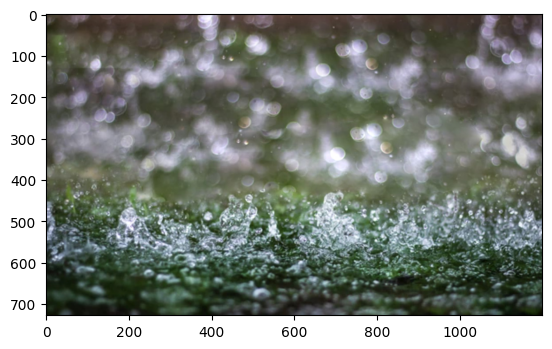

In [54]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Prediction:
Tensor:  tensor([5.0766e-02, 9.9542e-01, 1.1897e-04, 1.3162e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


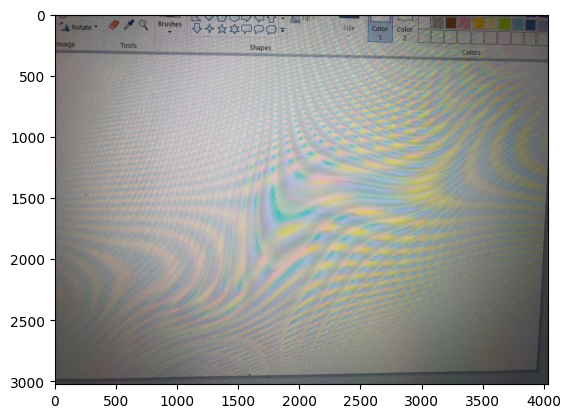

In [55]:
random_image_prediction('https://preview.redd.it/qtol18a4noo11.jpg?auto=webp&s=881c5068a0634d155d9341faed50e344a4fc6c61')

Prediction:
Tensor:  tensor([0.0014, 0.0022, 0.0043, 0.9282], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: rain


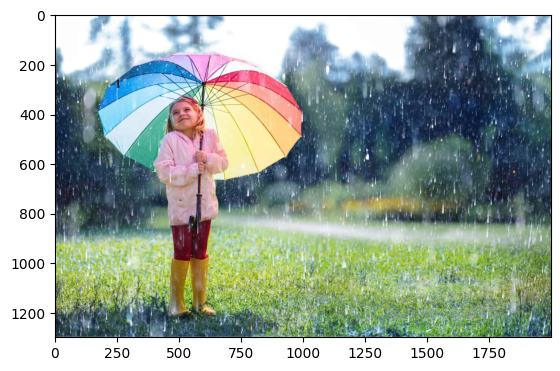

In [56]:
random_image_prediction('https://devonwithkids.co.uk/wp-content/uploads/2020/07/Child-with-umbrella.jpg')

Prediction:
Tensor:  tensor([0.0761, 0.0536, 0.8272, 0.0024], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


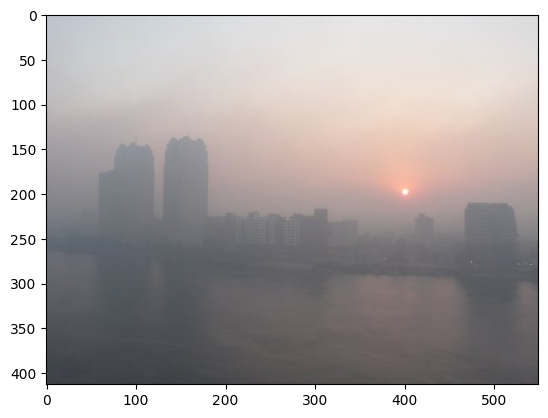

In [57]:
random_image_prediction('https://media-cdn.tripadvisor.com/media/photo-s/10/60/69/07/hazy-morning-view-of.jpg')

Prediction:
Tensor:  tensor([0.0019, 0.6198, 0.0019, 0.0016], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


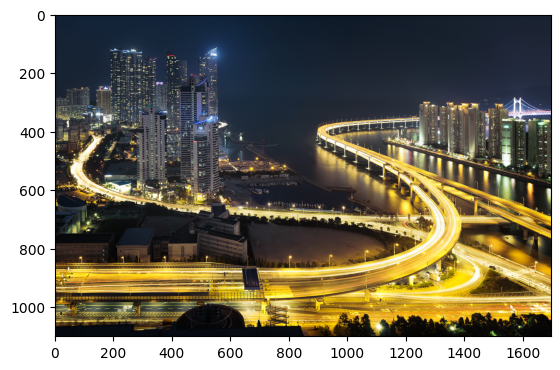

In [58]:
random_image_prediction('https://iso.500px.com/wp-content/uploads/2014/09/sharp-photo22.jpg')

Prediction:
Tensor:  tensor([0.9634, 0.2463, 0.0185, 0.0012], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: blur


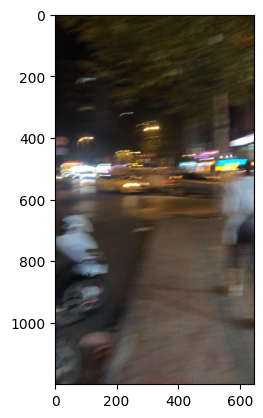

In [59]:
random_image_prediction('https://i.pinimg.com/736x/45/f7/2e/45f72e0e5eb524e2b2fb8ad4ff8d6777.jpg')

Prediction:
Tensor:  tensor([0.0107, 0.0401, 0.0023, 0.0412], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


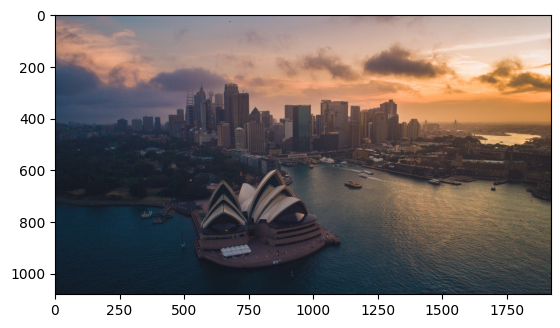

In [60]:
random_image_prediction('https://cdn.shopify.com/s/files/1/1901/8767/articles/Pat-kay-7-tips-for-shooting-razor-sharp-images-1_1920x.jpg?v=1608345303')

69.45133209228516
Label: rain
mask: demoir

tensor([5.4966e-04, 7.4749e-03, 3.2003e-03, 6.0859e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)


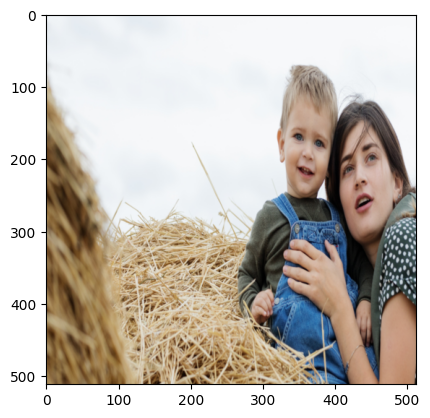

In [61]:
predict_single(*val_dataset[3282]) #checking out the predictions of some images from the validation dataset.

In [62]:
val_dataset.im_path(3282)

'../data/test/demoir/clear_gt/image_312.jpg'

In [63]:
PATH = os.path.join('../saved_models', datetime.now().strftime('mobilevit_full_mixed_regularized_24_05_23.pt'))
torch.save(model.state_dict(), PATH)

### Testing mixed data

In [64]:
val_dataset_mixed = myDataset(_C.VAL_PATH_MIXED, transform = val_trans)

In [65]:
len(val_dataset_mixed)

2023

In [66]:
val_loader_mixed = DataLoader(val_dataset_mixed, _C.BATCH_SIZE * 2, num_workers = 12)

In [67]:
val_dl_mixed = DeviceDataLoader(val_loader_mixed, device)

In [68]:
evaluate(model, val_dl_mixed)

  0%|          | 0/253 [00:00<?, ?it/s]

blur
prec 0.9999999999999996, rec 0.9802273850716753, f2 0.990014977533199
demoir
prec 0.8649350649350642, rec 0.998999999999999, f2 0.9271461716932372
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.997002997002996, rec 0.9755620723362649, f2 0.9861660079046373


{'val_loss': 0.07069192081689835,
 'val_score': 0.9725106902866104,
 'val_score_blur': 0.990014977533199,
 'val_score_haze': 0.0,
 'val_score_rain': 0.9861660079046373,
 'val_score_demoir': 0.9271461716932372}

In [ ]:
predict_single(*val_dataset_mixed[10])

In [69]:
model = load_model('../saved_models/mobilevit_full_mixed_regularized_24_05_23.pt')

In [71]:
dummy_input = torch.randn(1, 3, 512, 512, device="cuda")
model = load_model('../saved_models/mobilevit_full_mixed_regularized_24_05_23.pt')

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model, dummy_input, "../saved_models/exported/final_24_05_23.onnx", verbose=True, input_names=input_names, output_names=output_names)

In [72]:
!pip install onnx

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [73]:
import onnx
import time
# Load the ONNX model
loaded_model = onnx.load("../saved_models/exported/final_24_05_23.onnx")

In [74]:
# Check that the model is well formed
onnx.checker.check_model(loaded_model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(loaded_model.graph))

graph torch_jit (
  %actual_input[FLOAT, 1x3x512x512]
) initializers (
  %mvit.0.transformer.layers.0.0.norm.weight[FLOAT, 144]
  %mvit.0.transformer.layers.0.0.norm.bias[FLOAT, 144]
  %mvit.0.transformer.layers.0.0.fn.to_out.0.bias[FLOAT, 144]
  %mvit.0.transformer.layers.0.1.norm.weight[FLOAT, 144]
  %mvit.0.transformer.layers.0.1.norm.bias[FLOAT, 144]
  %mvit.0.transformer.layers.0.1.fn.net.0.bias[FLOAT, 288]
  %mvit.0.transformer.layers.0.1.fn.net.3.bias[FLOAT, 144]
  %mvit.0.transformer.layers.1.0.norm.weight[FLOAT, 144]
  %mvit.0.transformer.layers.1.0.norm.bias[FLOAT, 144]
  %mvit.0.transformer.layers.1.0.fn.to_out.0.bias[FLOAT, 144]
  %mvit.0.transformer.layers.1.1.norm.weight[FLOAT, 144]
  %mvit.0.transformer.layers.1.1.norm.bias[FLOAT, 144]
  %mvit.0.transformer.layers.1.1.fn.net.0.bias[FLOAT, 288]
  %mvit.1.transformer.layers.0.0.norm.weight[FLOAT, 192]
  %mvit.1.transformer.layers.0.0.norm.bias[FLOAT, 192]
  %mvit.1.transformer.layers.0.0.fn.to_out.0.bias[FLOAT, 192]
  %mvi

In [75]:
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [82]:
import onnxruntime as ort
print(ort.get_device())
ort_session = ort.InferenceSession("../saved_models/exported/final_19_05_23.onnx")

inputs = val_dataset[10][0].detach().unsqueeze(0).numpy()
print(inputs.shape)
starttime = time.time()
outputs = ort_session.run(
    None,
    {"actual_input": inputs},
)
print(1000*(time.time() - starttime))
print(outputs[0])

CPU
(1, 3, 512, 512)
128.87907028198242
[[9.7170240e-01 4.8860908e-04 2.2813559e-02 6.8776888e-01]]


Label: blur rain
mask: blur

tensor([9.7170e-01, 4.8860e-04, 2.2814e-02, 6.8777e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)


'../data/test/blur/14_IPHONE-7_F.jpeg'

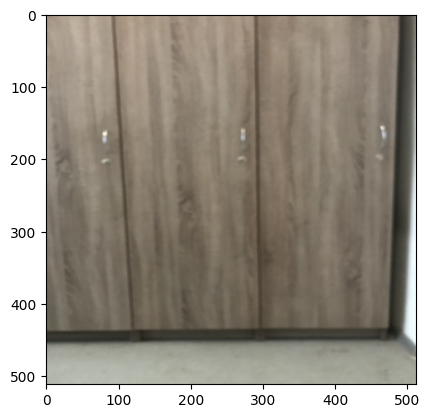

In [57]:
predict_single(*val_dataset[10])

In [45]:
loaded_model = CustomModelFirst().to(device)

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


In [46]:
loaded_model.load_state_dict(torch.load('../saved_models/mobilenetv2_full_data_750_14_05_23.pt'))

<All keys matched successfully>

In [47]:
loaded_model.to(device)
loaded_model.eval()

CustomModelFirst(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [48]:
evaluate(loaded_model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9892008639308845, rec 0.9252525252525243, f2 0.9561586638825893
demoir
prec 0.8631090487238969, rec 0.7439999999999992, f2 0.7991407089146468
haze
prec 0.9811320754716973, rec 0.9966666666666659, f2 0.9888383629594001
rain
prec 0.9459999999999991, rec 0.924731182795698, f2 0.9352446861092372


{'val_loss': 0.052983760833740234,
 'val_score': 0.9250608272501084,
 'val_score_blur': 0.9561586638825893,
 'val_score_haze': 0.9888383629594001,
 'val_score_rain': 0.9352446861092372,
 'val_score_demoir': 0.7991407089146468}

In [53]:
evaluate(loaded_model, val_dl_mixed)

  0%|          | 0/253 [00:00<?, ?it/s]

blur
prec 0.9999999999999721, rec 0.017795353435491837, f2 0.034968431277284696
demoir
prec 0.9999999999999971, rec 0.35099999999999965, f2 0.5196150999255953
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.9831460674157292, rec 0.8553274682306932, f2 0.9147935180340021


{'val_loss': 2.7813589572906494,
 'val_score': 0.4716875350398104,
 'val_score_blur': 0.034968431277284696,
 'val_score_haze': 0.0,
 'val_score_rain': 0.9147935180340021,
 'val_score_demoir': 0.5196150999255953}